In [1]:
import numpy as np
import matplotlib as mat
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import multivelo as mv
scv.__version__

Global seed set to 0


'0.3.1'

In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
np.set_printoptions(suppress=True)

In [3]:
#Preprocessing the ATAC 

sampleID = ['Macaque_M1_PFC','Macaque_M2_PFC']

i = 0
for sample in sampleID: 
    i = i+1
    matrix_path = f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/filtered_feature_bc_matrix/'
    print(f'reading ATAC input from the mtx path : {matrix_path}')
    adata_atac = sc.read_10x_mtx(matrix_path, var_names='gene_symbols', cache=True, gex_only=False)
    adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]
    adata_atac = mv.aggregate_peaks_10x(adata_atac,
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/peak_annotation.tsv',
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/analysis/feature_linkage/feature_linkage.bedpe',
                                    verbose=True)
    mv.tfidf_norm(adata_atac)
    # subset the annotated cells from ATAC assay 
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/{sample}_celltype_annotation'
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    shared_cells_anno = pd.Index(np.intersect1d(adata_atac.obs_names, cell_annot.index))
    adata_atac = adata_atac[shared_cells_anno,:]
      adata_atac.obs_names = [f'{sample}_' + x for x in adata_atac.obs_names]
    adata_atac.var_names_make_unique()
    ## write the preprocessed ATAC anndata out
     ##concatenate the filtered anndata
    if i == 1: adata_atac_all = adata_atac
    
    if i > 1:
        adata_atac_all = adata_atac_all.concatenate(adata_atac)

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M1_PFC/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13117 genes with promoter peaks


  0%|          | 0/13117 [00:00<?, ?it/s]

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M2_PFC/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13464 genes with promoter peaks


  0%|          | 0/13464 [00:00<?, ?it/s]

In [4]:
### rename the index (cellid) after concatenation
adata_atac_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_atac_all.obs_names]

In [5]:
adata_atac_all

AnnData object with n_obs × n_vars = 20260 × 12858
    obs: 'batch'

In [6]:
adata_atac_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_ATAC_raw.h5ad')

In [7]:
sampleID = ['Macaque_M1_PFC','Macaque_M2_PFC']

i = 0
for sample in sampleID: 
    i = i+1
    loom_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/{sample}.loom'
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_controls_subtype_annotation/{sample}_celltype_annotation'
    print(f'loom file path is {loom_path}')
    print(f'cell annotation file path is {cell_anno_path}')
    adata_rna = scv.read(loom_path, cache=True)
    adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    ## subset annotated cells from RNA assay
    shared_cells_anno = pd.Index(np.intersect1d(adata_rna.obs_names, cell_annot.index))
    adata_rna = adata_rna[shared_cells_anno,:]
    ## assign celltypes
    adata_rna.obs['celltype'] = cell_annot['celltype']
    ### rename cells with sampleID
    adata_rna.obs_names = [f'{sample}_' + x for x in adata_rna.obs_names]
    adata_rna.var_names_make_unique()
    ##save rna assay as h5ad
      ##concatenate the filtered loom files
    if i == 1: adata_rna_all = adata_rna
    # concatenate the three loom
    if i > 1:
        adata_rna_all = adata_rna_all.concatenate(adata_rna)


loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M1_PFC.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M1_PFC_celltype_annotation
loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M2_PFC.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M2_PFC_celltype_annotation


In [8]:
### rename the index (cellid) after concatenation
adata_rna_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_rna_all.obs_names]

In [10]:
adata_rna_all

AnnData object with n_obs × n_vars = 20260 × 34884
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
adata_rna_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_RNA_raw.h5ad')

In [3]:
adata_atac_all = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_ATAC_raw.h5ad')

In [4]:
adata_rna_all = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_RNA_raw.h5ad')

In [5]:
scv.pp.filter_and_normalize(adata_rna_all, min_shared_counts=10)

Filtered out 24495 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [6]:
adata_rna_all

AnnData object with n_obs × n_vars = 20260 × 10389
    obs: 'celltype', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'log1p'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
shared_cells = pd.Index(np.intersect1d(adata_rna_all.obs_names, adata_atac_all.obs_names))
shared_genes_assay = pd.Index(np.intersect1d(adata_rna_all.var_names, adata_atac_all.var_names))

In [8]:
len(shared_cells), len(shared_genes_assay)

(20260, 8860)

In [9]:
shared_genes_assay

Index(['AACS', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AAR2', 'AARS1',
       'AARS2', 'AASDHPPT',
       ...
       'ZSWIM6', 'ZSWIM7', 'ZSWIM8', 'ZUP1', 'ZW10', 'ZWILCH', 'ZXDC',
       'ZYG11B', 'ZYX', 'ZZEF1'],
      dtype='object', length=8860)

In [10]:
## import the genes tested for dPSI
PSI_genes = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_VS_HumanPFC/All_broad_Celltypes_dPSI_tested_genes_HumanAndMacaque_symbol.txt", header=None)[0])

In [11]:
PSI_genes

Index(['LAS1L', 'HECW1', 'MAD1L1', 'M6PR', 'ARF5', 'AK2', 'KDM1A', 'SLC25A13',
       'ST7', 'ST7',
       ...
       'GRIN2B', 'CYFIP1', 'SOCS7', 'SYNRG', 'PDE4DIPP2', 'ARHGAP23',
       'TUBGCP5', 'TYW1B', 'SRCIN1', 'MYO19'],
      dtype='object', name=0, length=2936)

In [12]:
## find the shared genes between RNA-ATAC assays and dPSI tested genes
shared_genes = pd.Index(np.intersect1d(shared_genes_assay, PSI_genes))

In [13]:
shared_genes

Index(['AACS', 'AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCA8', 'ABCB9', 'ABCC1',
       'ABCC10', 'ABCC8',
       ...
       'ZNF568', 'ZNF638', 'ZNF711', 'ZNF75A', 'ZNF83', 'ZNF875', 'ZRANB3',
       'ZSCAN18', 'ZSWIM7', 'ZYX'],
      dtype='object', length=2381)

In [14]:
adata_rna_all = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_RNA_raw.h5ad')

In [15]:
## subset the shared_cells and shared_genes from whole assay
adata_rna = adata_rna_all[shared_cells, shared_genes]

In [16]:
adata_rna

View of AnnData object with n_obs × n_vars = 20260 × 2381
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [17]:
adata_rna.var_names_make_unique()

In [18]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)

Normalized count data: X, spliced, unspliced.


/tmp/ipykernel_185535/2089892543.py:2: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


In [19]:
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

computing neighbors
    finished (0:00:26) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [20]:
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [21]:
set(adata_rna.obs['celltype'])

{'Astrocytes',
 'Endothelial',
 'Excitatory_Neurons',
 'Inhibitory_Neurons',
 'Microglia',
 'OPCs',
 'Oligodendrocytes'}

In [22]:
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['Astrocytes',
                                                      'Excitatory_Neurons',
                                                      'Inhibitory_Neurons',
                                                      'Microglia',
                                                      'Oligodendrocytes',
                                                      'OPCs'])]

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_spliced.unpliced_proportions_SpeciesComparison_dPSIgenes.pdf


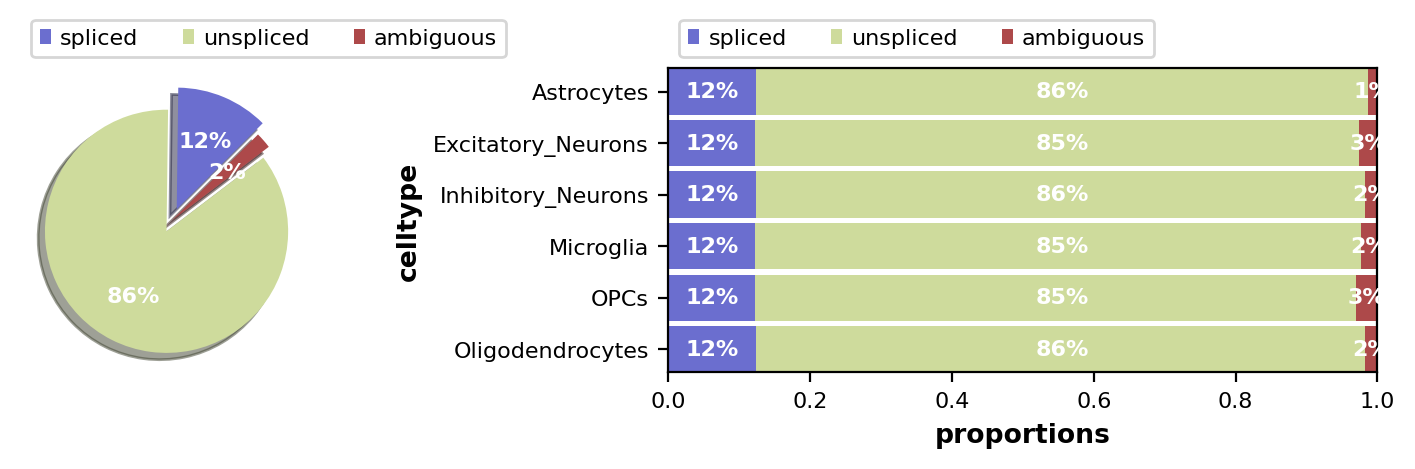

In [23]:
scv.pl.proportions(adata_rna, groupby='celltype',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_spliced.unpliced_proportions_SpeciesComparison_dPSIgenes.pdf' )

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna_umap_SpeciesComparison_dPSI_genes.pdf


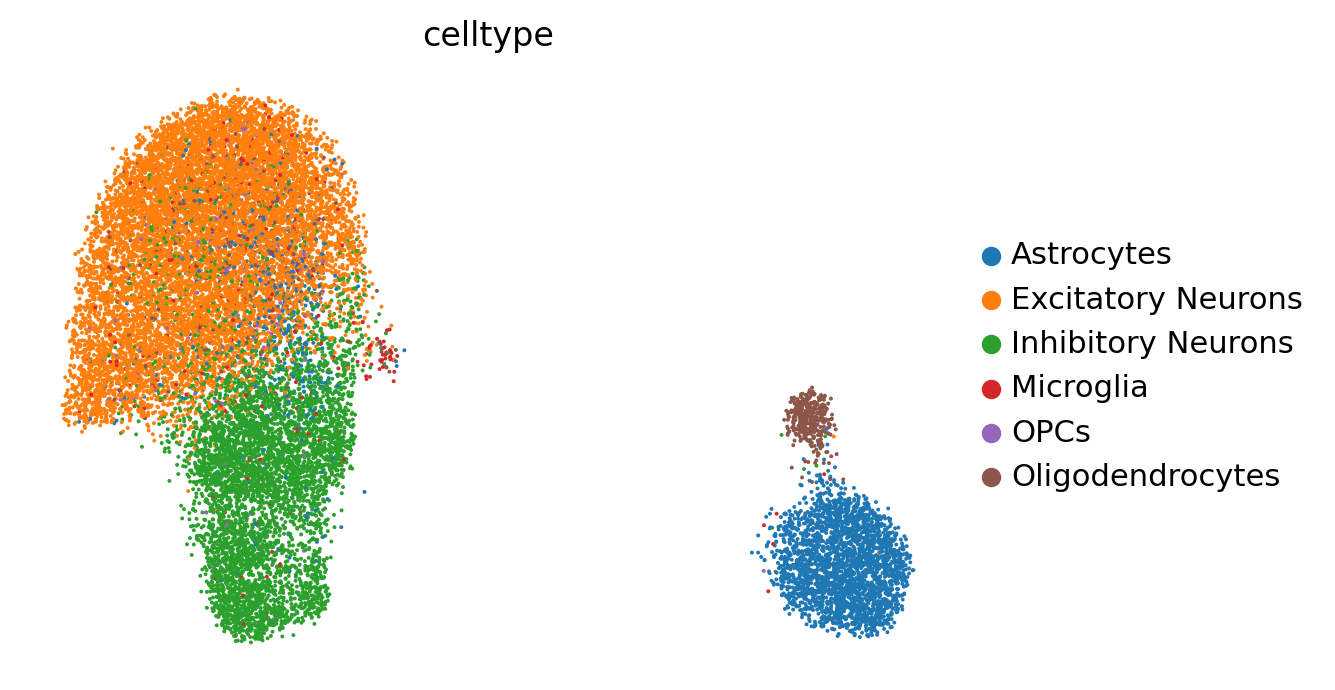

In [24]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype',size = 8, legend_loc='right margin',save = "/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna_umap_SpeciesComparison_dPSI_genes.pdf")

In [25]:
adata_rna.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna.SpeciesComparison_dPSIgenes.celltype.filtered_normalized.h5ad')

In [27]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_cells.txt", header=None)[0])

In [29]:
adata_atac_all.obs_names

Index(['Macaque_M1_PFC_AAACAGCCAAACTCAT-1',
       'Macaque_M1_PFC_AAACAGCCAATTAACC-1',
       'Macaque_M1_PFC_AAACAGCCACATACTG-1',
       'Macaque_M1_PFC_AAACAGCCAGTTAAAG-1',
       'Macaque_M1_PFC_AAACAGCCATAAGTTC-1',
       'Macaque_M1_PFC_AAACAGCCATAGCAGG-1',
       'Macaque_M1_PFC_AAACATGCATAATTGC-1',
       'Macaque_M1_PFC_AAACCAACAACTGGCT-1',
       'Macaque_M1_PFC_AAACCGAAGATAGACG-1',
       'Macaque_M1_PFC_AAACCGAAGCGGATTT-1',
       ...
       'Macaque_M2_PFC_TTTGTTGGTAATCCCT-1',
       'Macaque_M2_PFC_TTTGTTGGTATTGTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTCGAAGTC-1',
       'Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1',
       'Macaque_M2_PFC_TTTGTTGGTGCTTTAC-1',
       'Macaque_M2_PFC_TTTGTTGGTGTCACGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTGCATCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTTACTTG-1'],
      dtype='object', length=20260)

In [30]:
np.all(nn_cells == adata_atac_all.obs_names)

True

In [31]:
adata_atac_all

AnnData object with n_obs × n_vars = 20260 × 12858
    obs: 'batch'

In [32]:
mv.knn_smooth_chrom(adata_atac_all, nn_idx, nn_dist)

In [33]:
shared_cells_new = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac_all.obs_names))

In [34]:
shared_cells_new

Index(['Macaque_M1_PFC_AAACAGCCAAACTCAT-1',
       'Macaque_M1_PFC_AAACAGCCAATTAACC-1',
       'Macaque_M1_PFC_AAACAGCCACATACTG-1',
       'Macaque_M1_PFC_AAACAGCCAGTTAAAG-1',
       'Macaque_M1_PFC_AAACAGCCATAAGTTC-1',
       'Macaque_M1_PFC_AAACAGCCATAGCAGG-1',
       'Macaque_M1_PFC_AAACATGCATAATTGC-1',
       'Macaque_M1_PFC_AAACCAACAACTGGCT-1',
       'Macaque_M1_PFC_AAACCGAAGATAGACG-1',
       'Macaque_M1_PFC_AAACCGAAGCGGATTT-1',
       ...
       'Macaque_M2_PFC_TTTGTTGGTAATCCCT-1',
       'Macaque_M2_PFC_TTTGTTGGTATTGTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTCGAAGTC-1',
       'Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1',
       'Macaque_M2_PFC_TTTGTTGGTGCTTTAC-1',
       'Macaque_M2_PFC_TTTGTTGGTGTCACGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTGCATCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTTACTTG-1'],
      dtype='object', length=19856)

In [35]:
adata_atac = adata_atac_all[shared_cells_new, shared_genes]

In [36]:
adata_atac

View of AnnData object with n_obs × n_vars = 19856 × 2381
    obs: 'batch'
    layers: 'Mc'
    obsp: 'connectivities'

In [37]:
adata_atac.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_atac.SpeciesComparison_dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [3]:
adata_atac = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_atac.dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [4]:
adata_rna = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna.dPSIgenes.celltype.filtered_normalized.h5ad')

In [38]:
adata_rna

AnnData object with n_obs × n_vars = 19856 × 2381
    obs: 'celltype', 'batch', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [39]:
adata_atac

View of AnnData object with n_obs × n_vars = 19856 × 2381
    obs: 'batch'
    layers: 'Mc'
    obsp: 'connectivities'

In [40]:
# This will take a while. Parallelization is high recommended.
#mv.settings.VERBOSITY = 0
adata_result = mv.recover_dynamics_chrom(adata_rna,
                                         adata_atac,
                                         max_iter=5,
                                         init_mode="invert",
                                         parallel=True,
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500,
                                         extra_color_key='celltype'
                                        )

/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2381 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed s

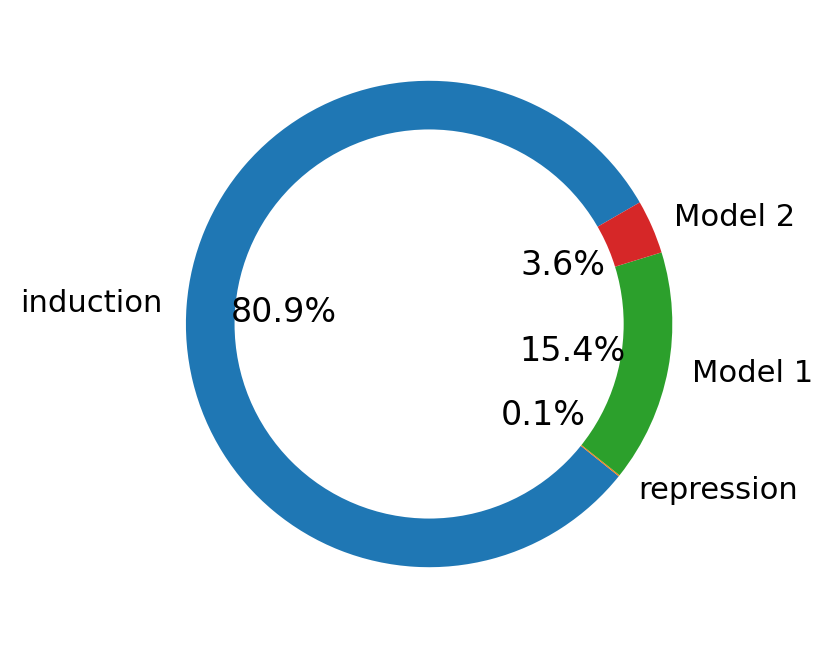

In [41]:
mv.pie_summary(adata_result)

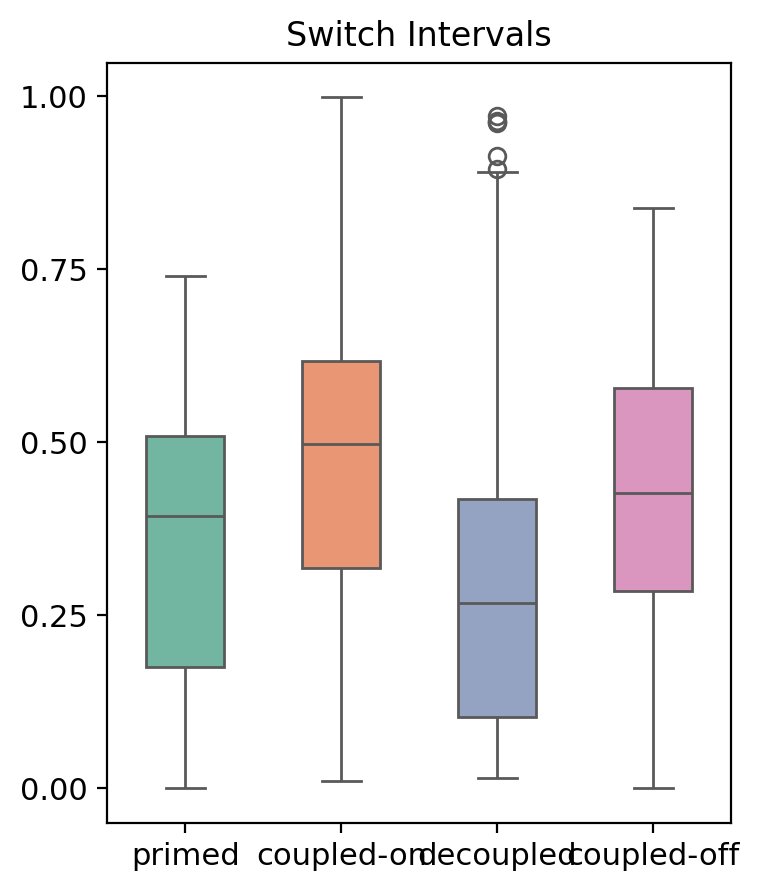

In [42]:
mv.switch_time_summary(adata_result)

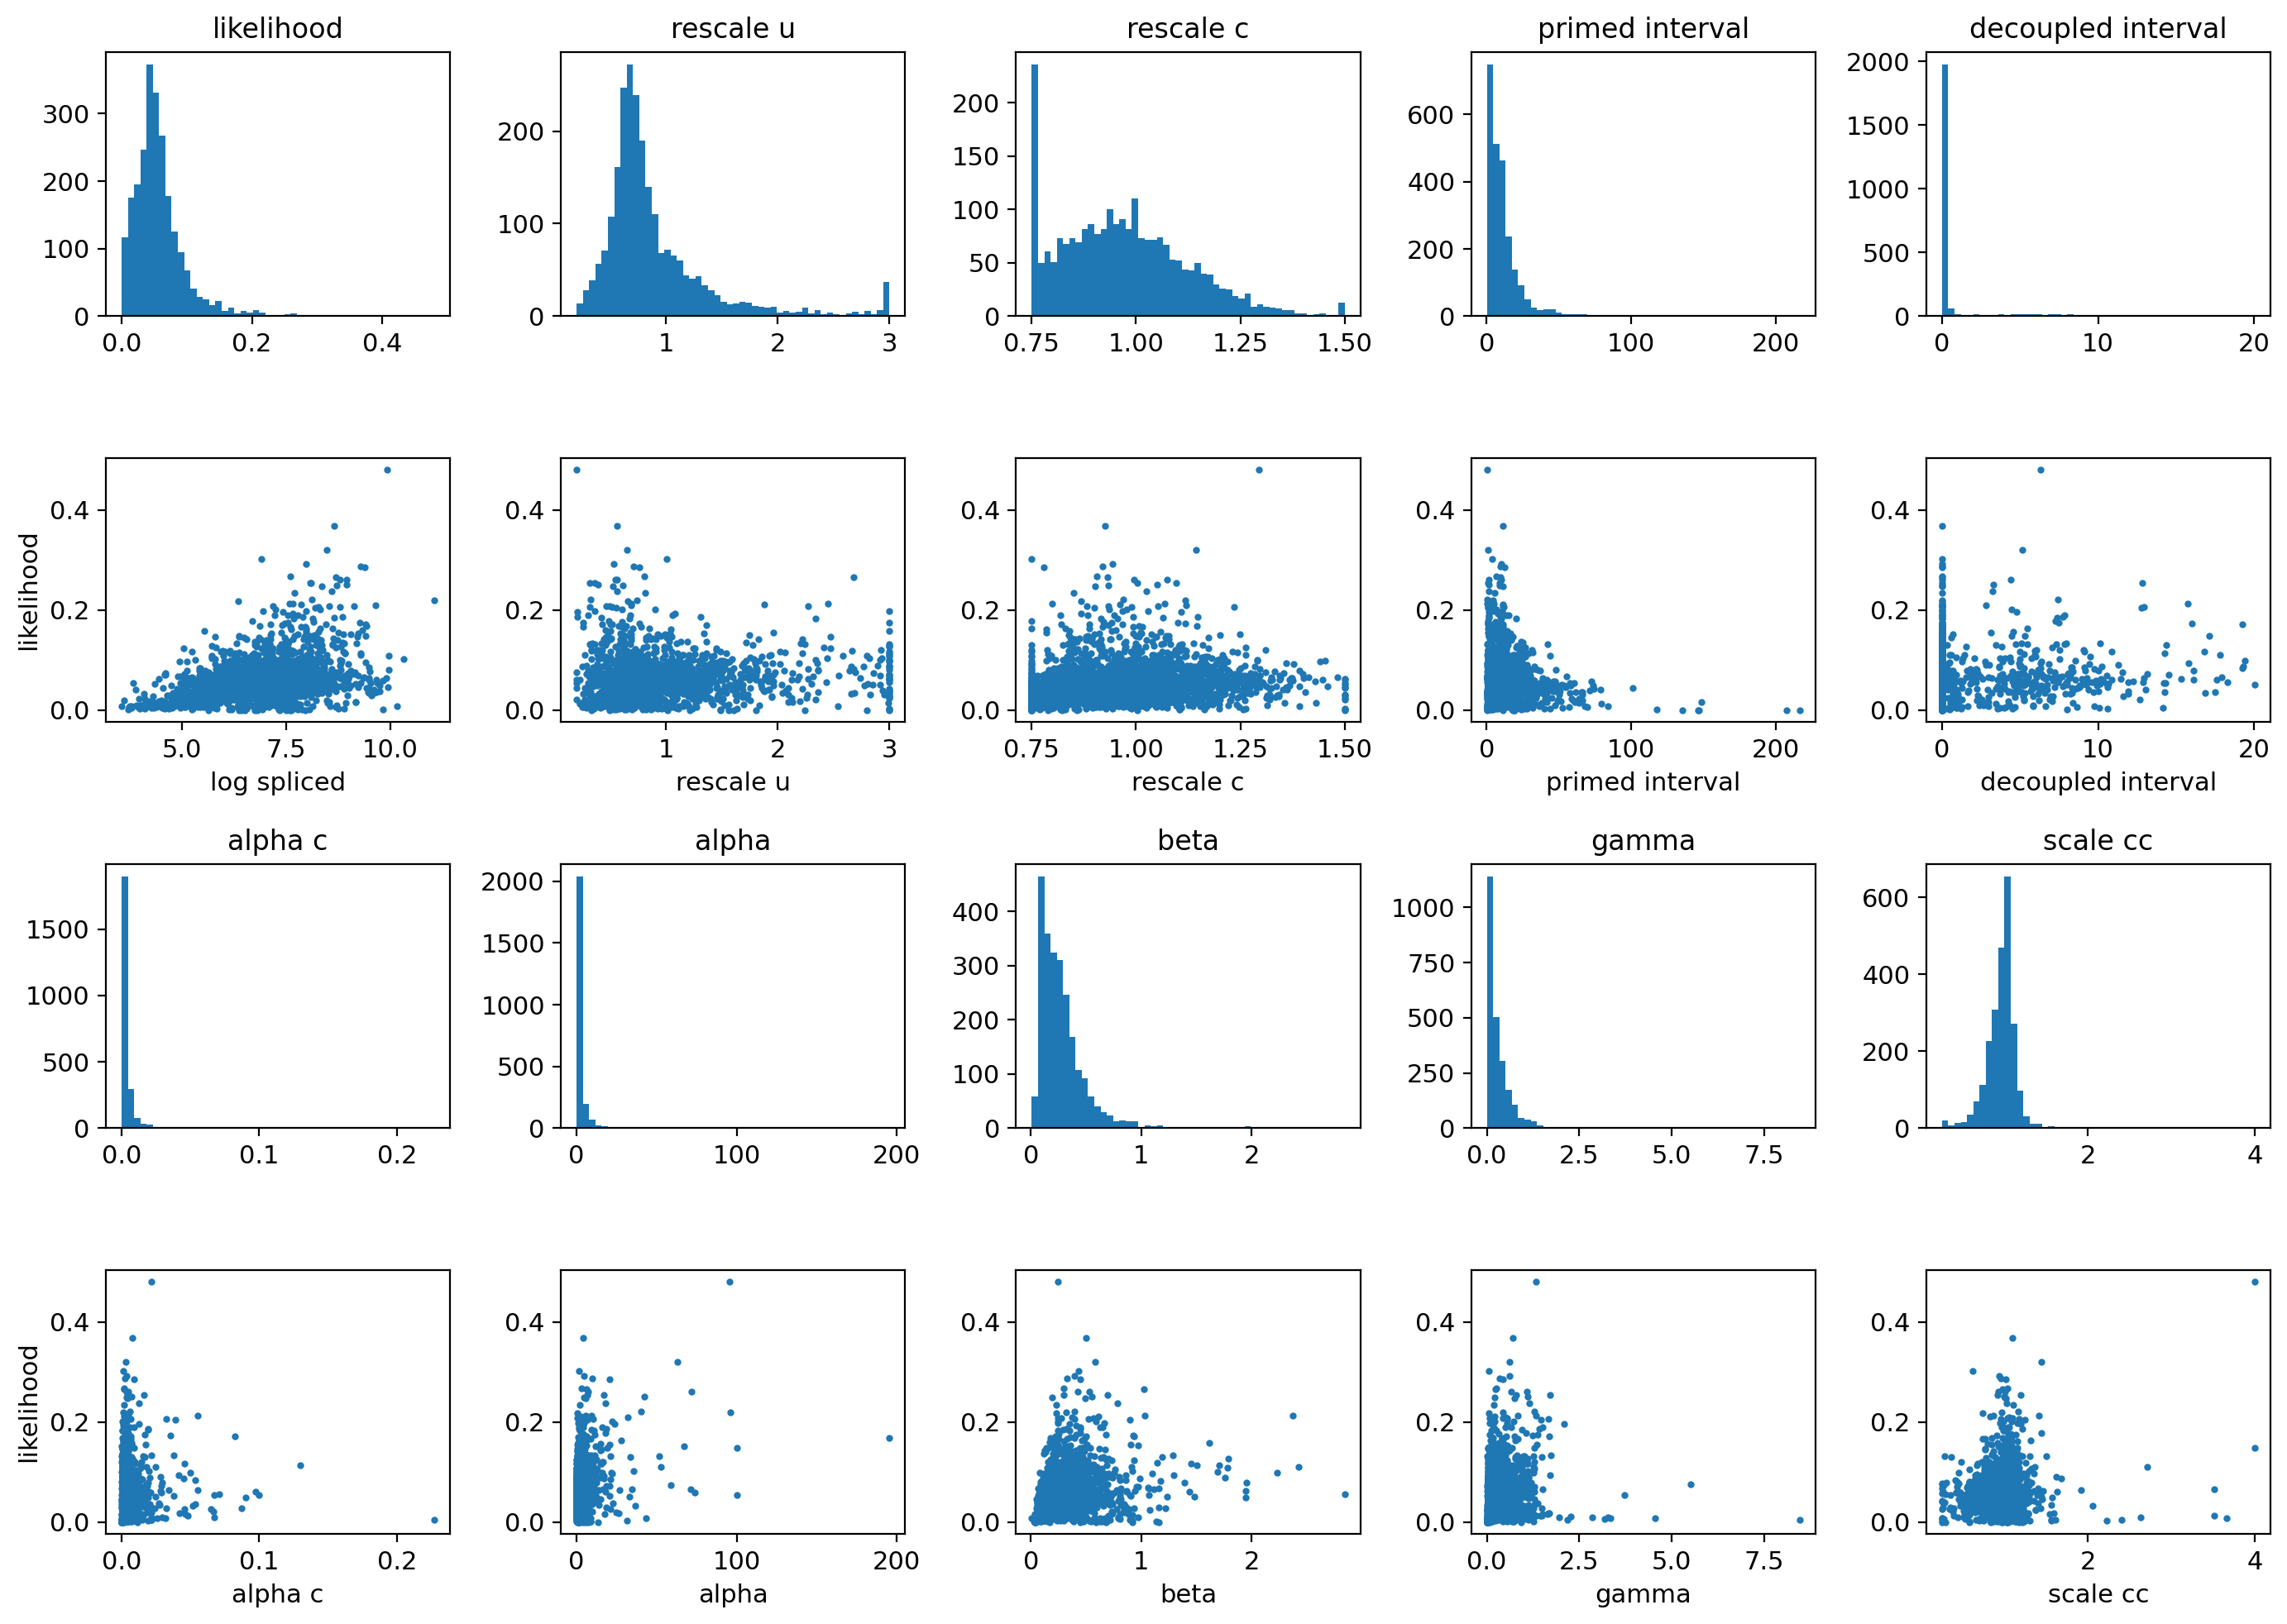

In [44]:
mv.likelihood_plot(adata_result)

In [45]:
#Computing velocity stream and latent time
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/56 cores)


/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/19856 [00:00<?, ?cells/s]

    finished (0:01:31) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 2 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:06) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:06) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_SpeciesComparison_dPSItested_genes.pdf


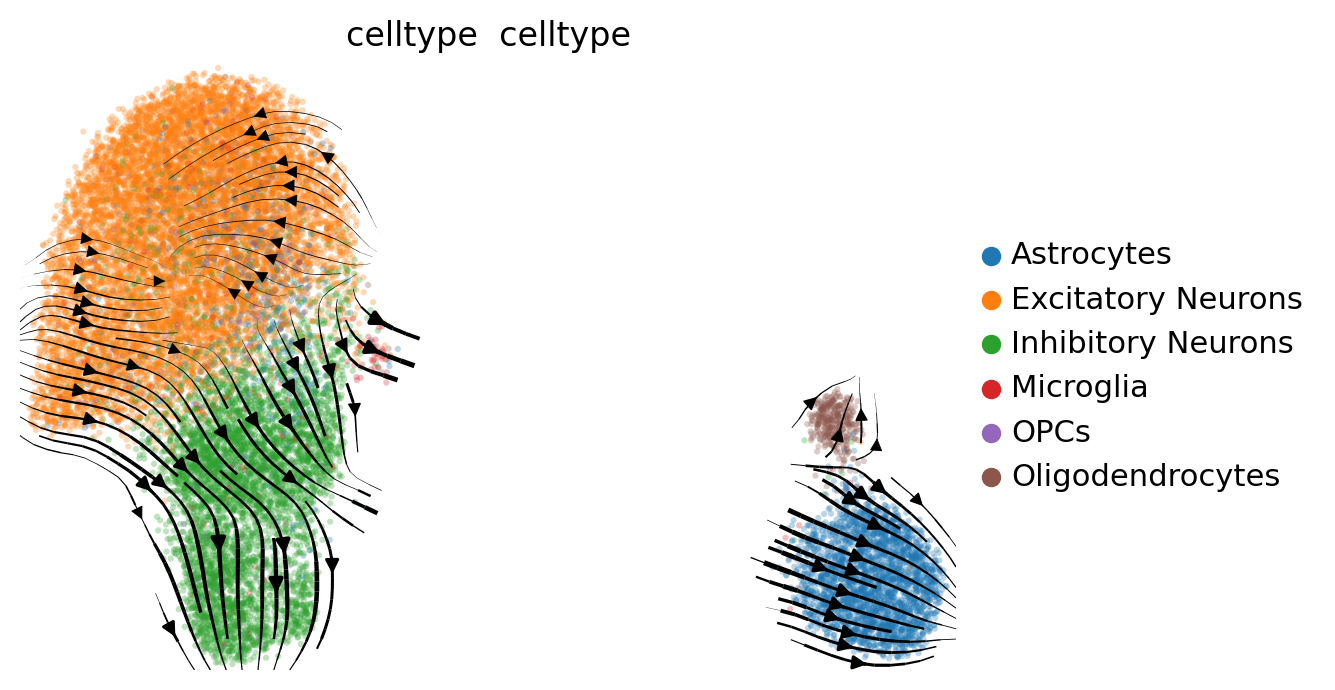

In [46]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype',size = 20, legend_loc='right margin',layer='celltype', save = '/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_SpeciesComparison_dPSItested_genes.pdf')

In [47]:
### add sampleID 
adata_result.obs['IndividualID'] = [x.split('_')[1][:] for x in adata_result.obs_names]
adata_result.obs['Region'] = [x.split('_')[2][:] for x in adata_result.obs_names]
#adata_result.obs['SampleID'] = f'adata_result.obs['IndividualID']_adata_result.obs['Region']'

In [48]:
adata_result.obs['SampleID'] = adata_result.obs['IndividualID'].astype(str) + adata_result.obs['Region']

In [49]:
adata_result.obs

,celltype,batch,n_counts,velo_s_norm_self_transition,root_cells,end_points,velo_s_norm_pseudotime,latent_time,IndividualID,Region,SampleID
Macaque_M1_PFC_AAACAGCCAAACTCAT-1,Astrocytes,0,205.999969,0.236267,0.013936,0.730965,0.639425,0.224138,M1,PFC,M1PFC
Macaque_M1_PFC_AAACAGCCAATTAACC-1,Inhibitory_Neurons,0,205.999985,0.205708,1.000000,0.001361,0.917836,0.845417,M1,PFC,M1PFC
Macaque_M1_PFC_AAACAGCCACATACTG-1,Inhibitory_Neurons,0,206.000000,0.233030,0.228933,0.015166,0.932624,0.846010,M1,PFC,M1PFC
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1,Excitatory_Neurons,0,206.000000,0.181712,0.015009,0.713936,0.978904,0.944778,M1,PFC,M1PFC
Macaque_M1_PFC_AAACAGCCATAAGTTC-1,Excitatory_Neurons,0,206.000000,0.253883,0.011555,0.934441,0.967236,0.920083,M1,PFC,M1PFC
...,...,...,...,...,...,...,...,...,...,...,...
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1,Excitatory_Neurons,1,205.999969,0.201094,0.040764,0.190825,0.983010,0.917240,M2,PFC,M2PFC
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1,Excitatory_Neurons,1,206.000015,0.228655,0.015428,0.440718,0.963352,0.925554,M2,PFC,M2PFC
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1,Astrocytes,1,205.999969,0.097374,0.023500,0.366696,0.644431,0.242858,M2,PFC,M2PFC
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1,Inhibitory_Neurons,1,206.000015,0.225248,0.013565,0.758962,0.965936,0.890595,M2,PFC,M2PFC


saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_SpeciesComparison_dPSItested_genes_bySampleID.pdf


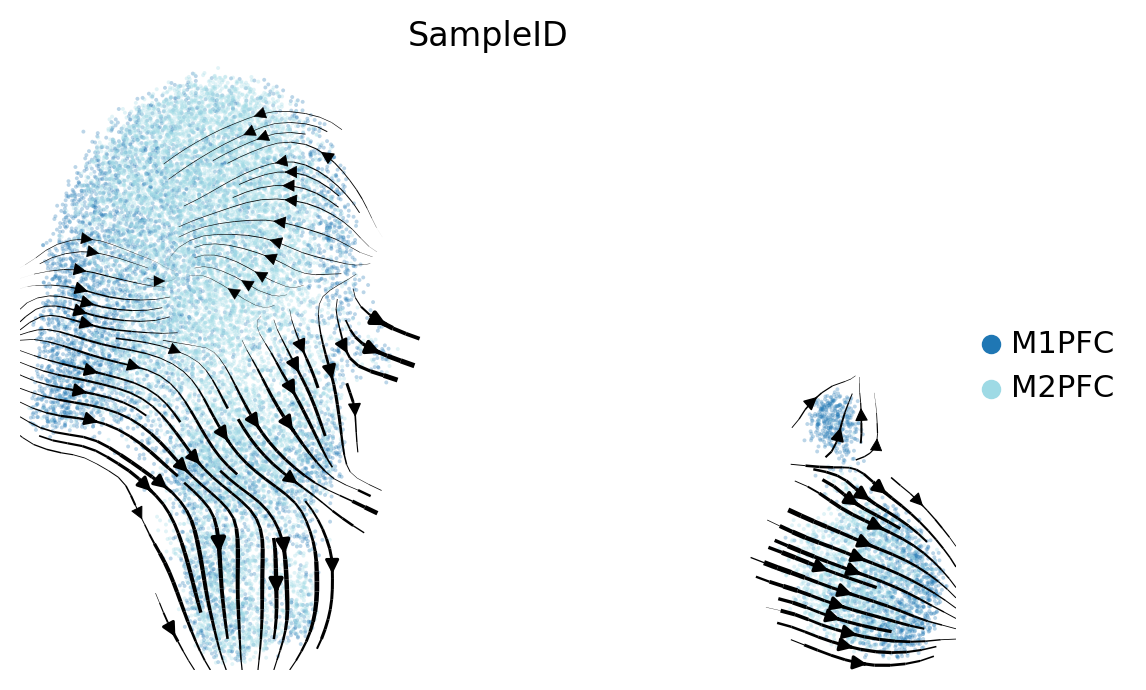

In [50]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='SampleID',palette='tab20',colorbar=True, size = 8, legend_loc='right margin',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_SpeciesComparison_dPSItested_genes_bySampleID.pdf')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/56 cores)


/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/19856 [00:00<?, ?cells/s]

    finished (0:01:31) --> added 
    'velo_chrom_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:06) --> added
    'velo_chrom_norm_umap', embedded velocity vectors (adata.obsm)


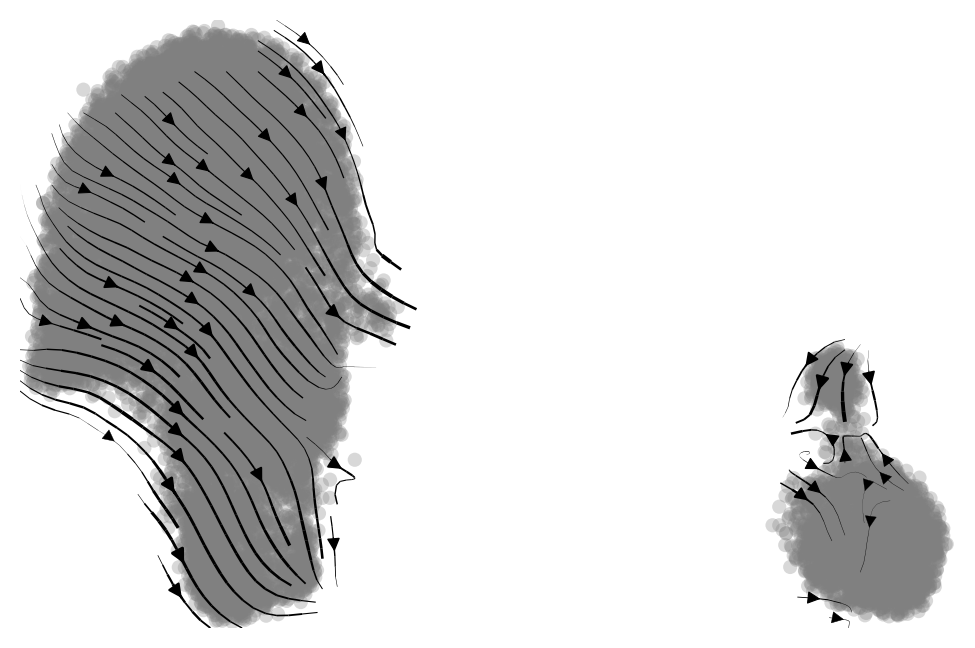

In [51]:
# velocity by atac
mv.velocity_embedding_stream(adata_result, basis='umap',vkey='velo_chrom')

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_ATAC_velocity_stream_SpeciesComparison_dPSItested_genes_byCelltype.pdf


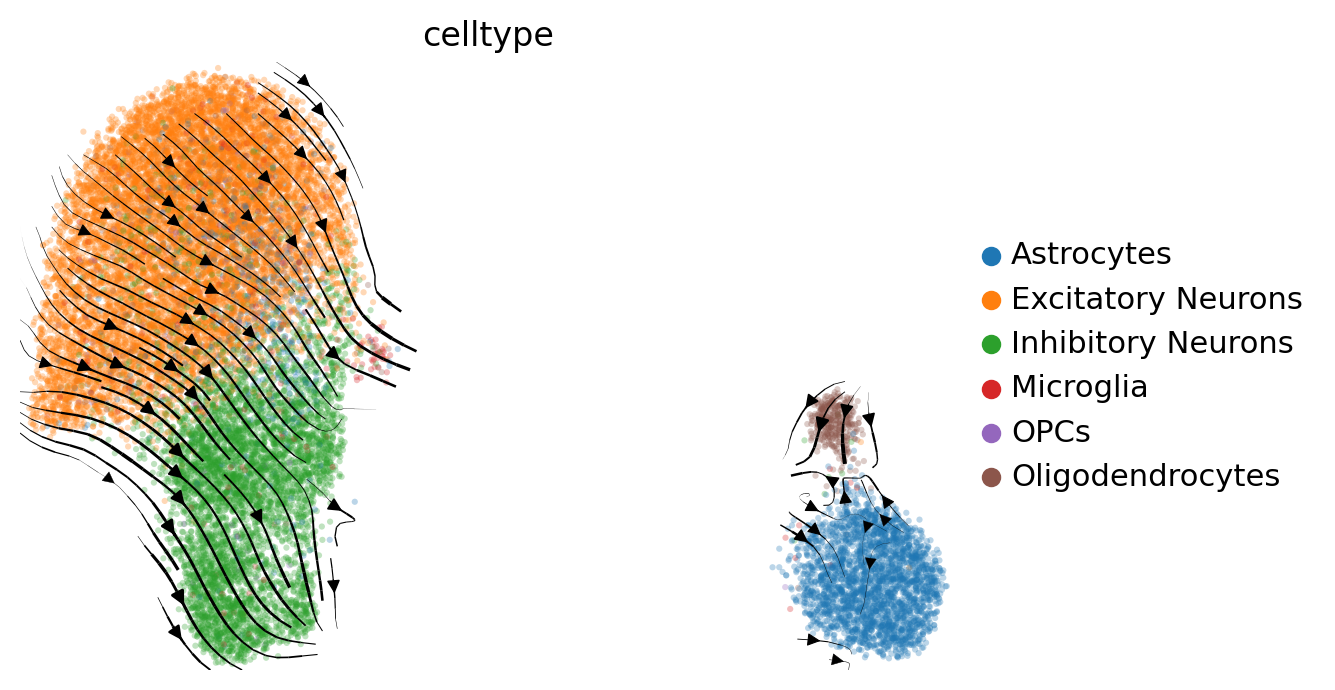

In [52]:
# plot velocity stream by velo_chrom
mv.velocity_embedding_stream(adata_result,color='celltype',size = 20, legend_loc='right margin', basis='umap',vkey='velo_chrom',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_ATAC_velocity_stream_SpeciesComparison_dPSItested_genes_byCelltype.pdf')

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_SpeciesComparison_latentTime.pdf


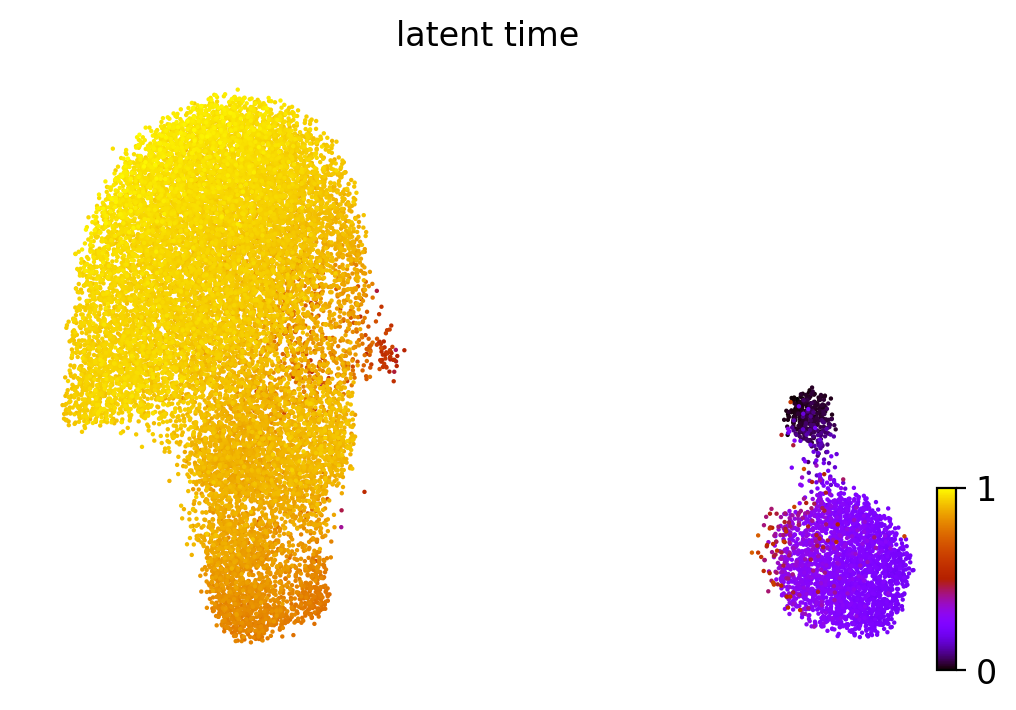

In [54]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=10,save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_SpeciesComparison_latentTime.pdf')

In [55]:
# Save the result for use later on
adata_result.write("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_SpeciesComparison_dPSItestedGenes.h5ad")

In [2]:
# Save the result for use later on
adata_result= sc.read_h5ad("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_SpeciesComparison_dPSItestedGenes.h5ad")

In [3]:
unique_fit_model = set(adata_result.var['fit_model'])

In [57]:
# get the model 1 genes
adata1 = adata_result[:, adata_result.var['fit_model'].values == 1]
# get the model 2 genes
adata2 = adata_result[:, adata_result.var['fit_model'].values == 2]

In [58]:
adata1.var

,Accession,Chromosome,End,Start,Strand,fit_alpha_c,fit_alpha,fit_beta,fit_gamma,fit_t_sw1,fit_t_sw2,fit_t_sw3,fit_scale_cc,fit_rescale_c,fit_rescale_u,fit_alignment_scaling,fit_model,fit_direction,fit_loss,fit_likelihood,fit_likelihood_c,fit_ssd_c,fit_var_c,fit_c0,fit_u0,fit_s0,fit_anchor_min_idx,fit_anchor_max_idx,fit_anchor_velo_min_idx,fit_anchor_velo_max_idx,velo_s_genes,velo_u_genes,velo_chrom_genes,velo_s_norm_genes,velo_chrom_norm_genes
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AACS,ENSMMUG00000011117,11,125063594,124978520,+,0.002696,2.259074,0.241526,0.320112,-0.037525,20.000212,21.588785,0.947252,0.972984,0.630771,1.165888,1.0,on,0.021587,0.082371,0.277889,11899.649292,0.752958,0.004525,0.000245,1.748477e-06,37.0,465.0,66.0,401.0,True,True,True,True,True
AAK1,ENSMMUG00000007868,13,39340248,39160062,+,0.004523,2.766491,0.153021,0.400887,-0.844144,20.004124,42.914573,1.006137,0.904630,0.458814,2.507538,1.0,on,0.015559,0.101312,0.284876,12404.644951,0.717598,0.029130,0.030548,3.853072e-03,72.0,271.0,103.0,270.0,True,True,True,True,True
AATK,ENSMMUG00000015514,16,77499815,77452417,-,0.008308,2.793426,0.453497,0.494103,-0.406963,20.008772,20.470085,0.965958,0.945871,0.565281,1.066239,1.0,on,0.009111,0.068815,0.282513,11178.914404,0.729528,0.006693,0.003196,4.498338e-04,20.0,488.0,105.0,467.0,True,True,True,True,True
ABAT,ENSMMUG00000046237,20,8825602,8716480,+,0.002182,5.261978,0.440304,0.463106,-0.054218,12.011709,14.261723,0.781740,1.182545,0.791309,2.227679,1.0,complete,0.004479,0.065356,0.314174,7467.268302,0.588531,0.007119,0.001330,1.990822e-05,31.0,255.0,51.0,225.0,True,True,True,True,True
ABCA5,ENSMMUG00000018608,16,65636081,65557549,-,0.004086,4.635264,0.400228,0.539632,8.097954,20.028136,20.619835,0.979113,1.120083,0.577554,1.030992,1.0,on,0.014801,0.119464,0.287115,11763.979224,0.710039,0.000000,0.000000,0.000000e+00,0.0,484.0,103.0,429.0,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF875,ENSMMUG00000047697,19,36602507,36573282,+,0.000793,0.094483,0.361508,0.051203,-0.103279,20.022477,23.297872,1.049803,1.016149,3.000000,2.654255,1.0,on,0.029013,0.028072,0.300121,2411.552691,0.645786,0.023711,0.000669,4.181330e-06,280.0,468.0,282.0,417.0,False,False,False,False,False
ZRANB3,ENSMMUG00000000765,12,20679677,20375415,-,0.002404,0.251800,0.075895,0.198323,-0.096585,20.021558,90.736842,1.064335,0.772364,0.671315,5.252632,1.0,on,0.000880,0.035242,0.279187,9879.301928,0.748951,0.026131,0.000549,2.976095e-06,68.0,163.0,104.0,163.0,False,False,False,False,False
ZSCAN18,ENSMMUG00000020503,19,57670814,57633697,-,0.006151,0.361812,0.123627,0.162865,-0.047588,20.025931,60.666667,0.794097,0.915495,0.558746,3.326667,1.0,on,0.002303,0.040863,0.259473,14222.124696,0.869642,0.032447,0.000339,1.777394e-06,44.0,194.0,92.0,190.0,False,False,False,False,False


In [59]:
adata2.var

,Accession,Chromosome,End,Start,Strand,fit_alpha_c,fit_alpha,fit_beta,fit_gamma,fit_t_sw1,fit_t_sw2,fit_t_sw3,fit_scale_cc,fit_rescale_c,fit_rescale_u,fit_alignment_scaling,fit_model,fit_direction,fit_loss,fit_likelihood,fit_likelihood_c,fit_ssd_c,fit_var_c,fit_c0,fit_u0,fit_s0,fit_anchor_min_idx,fit_anchor_max_idx,fit_anchor_velo_min_idx,fit_anchor_velo_max_idx,velo_s_genes,velo_u_genes,velo_chrom_genes,velo_s_norm_genes,velo_chrom_norm_genes
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABI1,ENSMMUG00000005078,9,27795709,27674614,-,0.003338,3.730124,0.454449,0.664138,-0.044345,13.692564,20.000000,1.037213,0.803076,1.022046,1.091904,2.0,complete,0.016511,0.083664,0.280038,12383.931798,0.745065,0.004913,0.001012,9.868732e-06,42.0,499.0,96.0,453.0,True,True,True,True,True
ADD1,ENSMMUG00000008379,5,3043742,2947716,+,0.002168,4.169165,0.372089,0.337984,-0.859217,20.019879,21.242236,1.397112,1.227115,0.728111,1.549689,2.0,complete,0.026416,0.067534,0.284279,11799.183841,0.724205,0.025676,0.044782,9.247231e-03,157.0,479.0,191.0,411.0,True,True,True,True,True
ADD3,ENSMMUG00000006233,9,110685612,110555963,+,0.008622,5.256099,0.298846,0.740206,-0.003322,20.003967,21.336406,1.040126,0.957878,0.286076,1.149770,2.0,complete,0.018183,0.036769,0.182048,4881.403109,1.184641,0.013604,0.000071,1.227887e-07,36.0,470.0,85.0,408.0,False,False,False,False,False
ADGRB2,ENSMMUG00000023401,1,192944149,192905685,+,0.005567,6.793290,0.623361,0.621930,2.126194,8.420263,32.113896,0.250319,0.845733,0.863422,1.149770,2.0,complete,0.021079,0.075634,0.267484,8540.917233,0.781074,0.013986,0.000000,0.000000e+00,65.0,499.0,168.0,406.0,True,True,True,True,True
AP2A1,ENSMMUG00000011612,19,49798442,49750472,+,0.004180,2.646552,0.388540,0.414249,-0.007132,7.745060,41.090085,0.250000,0.902437,0.999030,1.157773,2.0,complete,0.003956,0.057807,0.280378,8018.674974,0.736202,0.011824,0.000246,3.415123e-07,68.0,499.0,128.0,382.0,True,True,True,True,True
AP3M2,ENSMMUG00000014431,8,42765892,42747445,+,0.003667,1.954242,0.341165,0.368119,-0.008941,6.184921,14.395989,1.082293,0.905524,0.985901,1.378453,2.0,complete,0.002811,0.068545,0.268180,8235.981972,0.808370,0.024787,0.000471,7.272948e-07,137.0,499.0,158.0,457.0,True,True,True,True,True
APC,ENSMMUG00000000330,6,110371282,110225908,+,0.002454,6.485409,0.433040,0.585963,-0.776310,14.257193,20.000000,1.007382,0.993049,0.670081,1.355978,2.0,complete,0.031239,0.077068,0.270085,6020.312408,0.782332,0.017201,0.047095,1.052575e-02,131.0,499.0,205.0,492.0,True,True,True,True,True
ARF5,ENSMMUG00000046381,3,154063661,154056940,+,0.003763,3.052270,0.492581,0.712131,-0.030345,10.000478,29.694584,0.581647,0.971314,0.907419,1.247500,2.0,complete,0.005294,0.079294,0.269804,11215.423454,0.804196,0.017923,0.001535,1.256714e-05,99.0,499.0,149.0,431.0,True,True,True,True,True
ARHGAP5,ENSMMUG00000016346,7,94222316,94150795,+,0.002684,20.464924,0.452501,0.774326,-0.164853,6.834314,31.568922,0.605621,0.956507,0.650408,1.507553,2.0,complete,0.048721,0.073146,0.184015,4597.564676,1.063634,0.025709,0.056383,3.129256e-03,168.0,499.0,246.0,430.0,True,True,True,True,True


In [60]:
adata1.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module1_genes_major.celltypes_SpeciesComparison_dPSItestedGenes_cells.txt', header=True, index=True)
adata1.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module1_genes_major.celltypes_SpeciesComparison_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [61]:
adata2.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module2_genes_major.celltypes_SpeciesComparison_dPSItestedGenes_cells.txt', header=True, index=True)
adata2.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module2_genes_major.celltypes_SpeciesComparison_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [64]:
all_cells = adata_result.obs.index
dPSI_filter_genes = adata_result.var.index
state_all = adata_result[:,dPSI_filter_genes].layers['fit_state']
state_all_df = pd.DataFrame(state_all)

In [65]:
state_all_df.index = all_cells
state_all_df.columns = dPSI_filter_genes

In [66]:
state_all_df

Gene,AACS,AAK1,AATK,ABAT,ABCA5,ABCA8,ABCB9,ABCC1,ABCC10,ABCC8,ABCD3,ABCE1,ABCF3,ABCG1,ABHD12,ABHD6,ABI1,ABI2,ABL2,ABLIM1,ABLIM2,ABLIM3,ABR,ABTB1,ACAA1,ACACB,ACADM,ACADSB,ACAP2,ACAP3,ACER3,ACO2,ACOT8,ACOT9,ACOX1,ACOX3,ACSL1,ACSL3,ACTN1,ACTN2,ACTN4,ACTR1A,ACTR2,ACTR3,ACTR3B,ACVR1C,ACVR2A,ADAM10,ADAM15,ADAM17,...,ZCCHC8,ZCWPW1,ZDHHC13,ZDHHC16,ZDHHC17,ZDHHC20,ZDHHC21,ZDHHC4,ZDHHC9,ZFAND1,ZFP62,ZFPM2,ZFYVE16,ZFYVE21,ZFYVE27,ZGRF1,ZMYM2,ZMYM4,ZMYM5,ZMYND8,ZNF121,ZNF142,ZNF189,ZNF207,ZNF226,ZNF227,ZNF248,ZNF250,ZNF276,ZNF277,ZNF283,ZNF326,ZNF334,ZNF33A,ZNF33B,ZNF37A,ZNF384,ZNF410,ZNF414,ZNF484,ZNF568,ZNF638,ZNF711,ZNF75A,ZNF83,ZNF875,ZRANB3,ZSCAN18,ZSWIM7,ZYX
Macaque_M1_PFC_AAACAGCCAAACTCAT-1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Macaque_M1_PFC_AAACAGCCAATTAACC-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Macaque_M1_PFC_AAACAGCCACATACTG-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Macaque_M1_PFC_AAACAGCCATAAGTTC-1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [67]:
# save the state matrix, index = cellID, header = geneName
state_all_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_SpeciesComparison_dPSItestedGenes_Cell_States_mtx.csv')

In [6]:
adata_result

AnnData object with n_obs × n_vars = 19856 × 2377
    obs: 'celltype', 'batch', 'n_counts', 'velo_s_norm_self_transition', 'root_cells', 'end_points', 'velo_s_norm_pseudotime', 'latent_time', 'IndividualID', 'Region', 'SampleID', 'velo_chrom_norm_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes', 'velo_s_norm_genes', 'velo_chrom_norm_genes'
    uns: 'SampleID_colors', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'velo_chrom_norm_graph', 'velo_chrom_norm_graph_neg', 'velo_chrom_norm_params', 'velo_chrom_

In [4]:
adata_result_exn = adata_result[adata_result.obs['celltype'] == "Excitatory_Neurons"]

In [7]:
adata_result_exn.obs

,celltype,batch,n_counts,velo_s_norm_self_transition,root_cells,end_points,velo_s_norm_pseudotime,latent_time,IndividualID,Region,SampleID,velo_chrom_norm_self_transition
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1,Excitatory_Neurons,0,206.000000,0.181712,0.015009,0.713936,0.978904,0.944778,M1,PFC,M1PFC,0.032907
Macaque_M1_PFC_AAACAGCCATAAGTTC-1,Excitatory_Neurons,0,206.000000,0.253883,0.011555,0.934441,0.967236,0.920083,M1,PFC,M1PFC,0.106348
Macaque_M1_PFC_AAACCGAAGCGGATTT-1,Excitatory_Neurons,0,206.000015,0.184525,0.017885,0.580677,0.988476,0.926000,M1,PFC,M1PFC,0.005542
Macaque_M1_PFC_AAACCGAAGTTGGATC-1,Excitatory_Neurons,0,205.999969,0.225620,0.008948,0.940807,0.971618,0.925549,M1,PFC,M1PFC,0.032322
Macaque_M1_PFC_AAACCGCGTAAGCACC-1,Excitatory_Neurons,0,206.000000,0.167198,0.022973,0.163924,0.963502,0.927833,M1,PFC,M1PFC,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1,Excitatory_Neurons,1,205.999969,0.235541,0.082558,0.103194,0.970207,0.899407,M2,PFC,M2PFC,0.076507
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1,Excitatory_Neurons,1,206.000015,0.186820,0.089764,0.047358,0.959050,0.887335,M2,PFC,M2PFC,0.010492
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1,Excitatory_Neurons,1,205.999985,0.238149,0.062669,0.140817,0.982232,0.911167,M2,PFC,M2PFC,0.054282
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1,Excitatory_Neurons,1,205.999969,0.201094,0.040764,0.190825,0.983010,0.917240,M2,PFC,M2PFC,0.055286


In [10]:
dPSI_filter_genes

Index(['AACS', 'AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCA8', 'ABCB9', 'ABCC1',
       'ABCC10', 'ABCC8',
       ...
       'ZNF568', 'ZNF638', 'ZNF711', 'ZNF75A', 'ZNF83', 'ZNF875', 'ZRANB3',
       'ZSCAN18', 'ZSWIM7', 'ZYX'],
      dtype='object', name='Gene', length=2377)

In [8]:
exn_cells = adata_result_exn.obs.index
dPSI_filter_genes = adata_result.var.index
state_exn = adata_result[exn_cells,dPSI_filter_genes].layers['fit_state']
state_exn_df = pd.DataFrame(state_exn)
state_exn_df.index = exn_cells
state_exn_df.columns = dPSI_filter_genes

In [9]:
# save the state matrix, index = cellID, header = geneName
state_exn_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_SpeciesComparison_dPSItestedGenes_ExN_Cell_States_mtx.csv')